In [1]:
from __future__ import division
import numpy as np
import pdb as pdb
import matplotlib.pyplot as plt
from math import pi
import pickle
import colormaps as cmaps
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import time
import array
from scipy import optimize
from collections import OrderedDict

plt.rcParams['figure.figsize']=[12,8]
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
cmapV=plt.cm.get_cmap('viridis')


blue=(114/255,158/255,206/255)
orange=(255/255,158/255,74/255)
green=(103/255,191/255,92/255)
red=(237/255,102/255,93/255)
purple=(173/255,139/255,201/255)


#CONSTANTS all in EV, meters, seconds
me=.511*10**6 #electron mass
c=299792458.0 #speed of light
mpc=3.086*10**22 #Mpc in m
zfinal=50. #end of simulation
sigT=6.652459*10**(-29.) #thomson cross section

#Cosmological parameters
h=0.67
YHe=0.24 #fraction of Helium from BBN
H0=100.*h*1000./mpc # Hubble constant in seconds
T0=2.73 #CMB temp today
Nnueff=3.046 #dof of Neutrinos
omegaM=0.1409/h**2 #matter density
omegaR=T0**4*4.48162687719e-7*(1+0.227107318*Nnueff)/h**2 #relativistic density
omegaK=0. #Curvature density
omegaDE=1-omegaM-omegaR-omegaK #Dark Energy density
aeq=4.15e-5/(omegaM*h**2) #matter radiation equaltiy
omegab=0.02226/h**2 #baryon density
nh0=(1-YHe)*11.3*omegab*h**2 #density of hydrogen today
alpha=1/137.
hbar=6.582e-16 #eV s
kb=8.61733e-5 #eV K^-1
radconst=4723. #eV/m^3 K^4 8*np.pi**5*kb**4*(1/(c*hbar*2*np.pi))**3/15.
rnot=np.sqrt(sigT*3/(8*np.pi))
Heco=YHe/(4.*(1.-YHe)) #Helium number fraction
EI=13.6 #Ionization energy of neutral hydrogen
As=2.2e-9
ns=0.964
kpivot=0.05 #Mpc^-1
tau_reio=0.0544

omegaM=0.1409/h**2 #matter density
omegab=0.02226/h**2 #baryon density
#CONSTANTS

zin=2000.
krange=[1e-4,10]


def HubbleRate(a):
    return H0*np.sqrt(omegaM/a**3+omegaK/a**2+omegaDE+omegaR/a**4)


def find_nearest(array, value):
    array = np.asarray(array)
    array[~np.isfinite(array)]=0.
    idx = (np.abs(array - value)).argmin()
    return idx

def conformal(a):
    N=1000
    if type(a) is not np.ndarray: a=np.asarray([a])
    if a.shape is (): a=np.asarray([a])
    it=a.size
    val=np.zeros(it)
    for i in range(it):
        aarr=np.exp(np.linspace(np.log(a[i]),np.log(1),N))
        da=(0-np.log(a[i]))/np.float(N)
        quad=1/(HubbleRate(aarr)*aarr)
        val[i]=c/mpc*(quad[1:]+quad[:-1]).sum()*da/2.
    return val

def sec_diff(x,y,axis=0):
    reshapearr=np.insert(np.ones(y.ndim-1,dtype=int),axis,int(x[2:].size))
    if axis==0:
        diff=(y[2:,...]-y[:-2,...])/(x[2:]-x[:-2]).reshape(reshapearr)
        diff=np.insert(np.insert(diff,0,diff[0,...],axis=axis),diff.shape[0]+1,diff[-1,...],axis=axis)
        return diff
    if axis==1:
        diff=(y[:,2:,...]-y[:,:-2,...])/(x[2:]-x[:-2]).reshape(reshapearr)
        diff=np.insert(np.insert(diff,0,diff[:,0,...],axis=axis),diff.shape[0]+1,diff[:,-1,...],axis=axis)
        return diff
    if axis==2:
        diff=(y[:,:,2:,...]-y[:,:,:-2,...])/(x[2:]-x[:-2]).reshape(reshapearr)
        diff=np.insert(np.insert(diff,0,diff[:,:,0,...],axis=axis),diff.shape[0]+1,diff[:,:,-1,...],axis=axis)
        return diff
    
def exp_tau_gen(a):
    expint=np.zeros(a.size)
    #taudot=nh0*sigT*xe(a)/a**2*mpc
    for i in range(a.size):
        ares=np.exp(np.linspace(np.log(a[i]),0,1000))
        confres=eta_int(ares)
        #thistaudot=nh0*sigT*xe(ares)/ares**2*mpc
        thistaudot=taudot(ares)
        dconf=np.abs(confres[1:]-confres[:-1])
        expint[i]=((thistaudot[1:]+thistaudot[:-1])*dconf).sum()/2.
    return expint
ares=10**(np.linspace(np.log10(1e-10),np.log10(1),4000))
eta_0=conformal(np.asarray([1e-10]))
eta_int=interp1d(ares,eta_0-conformal(ares))
a_int=interp1d(eta_0-conformal(ares),ares,bounds_error=False, fill_value=0.)


def plot_an(x, y, z, zplts, xlim=None,xscale='log',legloc=None, ylog=0,savfol=None,ylim=None,xlabel='x',ylabel='y',tit='title',pdf=None,legendbool=True,pltmarker=None,fig=None,ax=None,linestyle='-',legstr=r'$z$='):
    def find_nearest(array, value):
        array = np.asarray(array)
        array[~np.isfinite(array)]=0.
        idx = (np.abs(array - value)).argmin()
        return idx
    #Colors for plot
    import colormaps as cmaps
    plt.register_cmap(name='viridis', cmap=cmaps.viridis)
    cmapV=plt.cm.get_cmap('viridis')
    rgord=np.linspace(0,1,len(zplts))
    rgba=cmapV(rgord)
    prevind=-1
    if ax is None: fig, ax=plt.subplots(1,1)
    for cc in range(len(zplts)):
        indx=find_nearest(z,zplts[cc]) #find the bin closest to desired z-plot
        if indx == prevind: continue
        if indx == len(y[0,:]):indx-=1
        prevind = indx
        ax.plot(x,y[:,indx],lw=2,linestyle=linestyle, color=rgba[cc], marker=pltmarker, zorder=cc,label=legstr+'%s' % (z[indx]) )#/Gnorm[indx]

    if legendbool:
        ll=ax.legend(fontsize=14,loc=legloc,ncol=2,labelspacing=0.2,handlelength=0.75)
        ll.set_zorder(10000)
    ax.set_xlabel(xlabel,fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    #ax.set_title(r'$E_{\rm inj}=$%s $(m_e)$, $z_{\rm inj}=$%s, $N_{\rm tot}=$%s' % (int(Eparam*1000)/1000., int(1/ai-1), Ntot), fontsize=18)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_title(tit, fontsize=18)
    if xscale is 'log':
        ax.set_xscale('log')
    if ylog: ax.set_yscale('log')
    fig.tight_layout()
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if ax is None:
        if (savfol) or (pdf) is None:
            plt.show()
        elif pdf is None:
            plt.savefig(savfol+'z%s_E%s_N%s.pdf' % (int(1/ai-1),int(Eparam),int(Ntot)))
            plt.close(fig)
        else:
            plt.savefig(pdf)
            plt.close()

In [39]:
print((omegaM-omegab)*h**2)
omegab*h**2

0.11864


0.02226

In [2]:
from classy import Class
common_settings = {# wich output? ClTT, transfer functions delta_i and theta_i
                           'output':'tCl,pM,vTk',
                           # LambdaCDM parameters
                           'h':h,
                            'input_verbose':4,
                            'background_verbose':4,
                            'T_cmb':T0,
                           'Omega_b':omegab,
                           'Omega_cdm':omegaM-omegab,
                           'modes':'s',
                           #'tensor method':'photons',
                           #'k_output_values':kstr,
                           'N_ur':3.046,
                           'A_s':As,
                           'n_s':ns,
                            #'sigma8':0.8,
                           'tau_reio':tau_reio,
                           #'primordial_P_k_max_1/Mpc':10,
                            #'z_max_pk':2000.,
                            #'k_per_decade_for_pk':100,
                           #'k_per_decade_for_bao':100,
                           # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                           'YHe':YHe,
                           'l_max_g':80,
                           'l_max_pol_g':80,
                           'l_max_scalars':8000,
                           'k_pivot':kpivot,
                           #'radiation_streaming_trigger_tau_over_tau_k':1e6,
                           #'radiation_streaming_trigger_tau_c_over_tau':1e6,
                           #'ur_fluid_trigger_tau_over_tau_k':10,
                           # other output and precision parameters
                           #'P_k_max_1/Mpc':10.0,
                           'recombination':'HyRec',
                           'gauge':'newtonian',
                           'lensing':'no'}



In [3]:
M = Class()
M.struct_cleanup()  # clean output
M.empty()
M.set(common_settings)
M.compute()

In [4]:
s,k,tau = M.get_sources()
kplot=k[::50]

Has temp multipoles g


In [34]:
s.viewkeys()

dict_keys([u'mult_Pg_61', u'mult_Pg_60', u'mult_Pg_63', u'mult_Pg_62', u'mult_Pg_65', u'mult_Pg_64', u'mult_Pg_67', u'mult_Pg_66', u'mult_Pg_69', u'mult_Pg_68', u'mult_Tg_21', u'mult_Tg_20', u'mult_Tg_23', u'mult_Tg_22', u'mult_Tg_25', u'mult_Tg_24', u'mult_Tg_27', u'mult_Tg_26', u'mult_Tg_29', u'mult_Tg_28', u'mult_Pg_54', u'mult_Pg_55', u'mult_Pg_56', u'mult_Pg_57', u'mult_Pg_50', u'mult_Pg_51', u'mult_Pg_52', u'mult_Pg_53', u'mult_Pg_58', u'mult_Pg_59', u'mult_Tg_14', u'mult_Tg_15', u'mult_Tg_16', u'mult_Tg_17', u'mult_Tg_10', u'mult_Tg_11', u'mult_Tg_12', u'mult_Tg_13', u'mult_Tg_18', u'mult_Tg_19', u't0', u't1', u't2', u'mult_Pg_6', u'mult_Pg_7', u'mult_Pg_4', u'mult_Pg_5', u'mult_Pg_2', u'mult_Pg_3', u'mult_Pg_0', u'mult_Pg_1', u'mult_Pg_8', u'mult_Pg_9', u'mult_Tg_80', u'mult_Tg_78', u'mult_Tg_79', u'mult_Tg_76', u'mult_Tg_77', u'mult_Tg_74', u'mult_Tg_75', u'mult_Tg_72', u'mult_Tg_73', u'mult_Tg_70', u'mult_Tg_71', u'mult_Pg_49', u'mult_Pg_48', u'mult_Pg_43', u'mult_Pg_42', u'm

In [34]:
from classy import Class

def get_pert(karr,M):
    numk=np.int(np.floor(karr.size/30.))
    left=karr.size-numk*30
    for i in range(numk+1):
        if (i == numk): 
            if (len(karr[i*30:])>0): kstr=','.join(['%s' % num for num in karr[i*30:]])
            else: break
        else: kstr=','.join(['%s' % num for num in karr[i*30:(i+1)*30]])


        #############################################
        #
        # Cosmological parameters and other CLASS parameters
        #
        common_settings = {# wich output? ClTT, transfer functions delta_i and theta_i
                           'output':'tCl',#'mTk,vTk',
                           # LambdaCDM parameters
                           'h':h,
                           #'l_max_g':80,
                           #'l_max_scalars':8000,
                            'input_verbose':4,
                            'background_verbose':4,
                            'T_cmb':T0,
                           'Omega_b':omegab,
                           'Omega_cdm':omegaM-omegab,
                           'modes':'s',
                           #'tensor method':'photons',
                           'k_output_values':kstr,
                           'N_ur':3.046,
                           'A_s':As,
                           'n_s':ns,
                            #'sigma8':0.8,
                           'tau_reio':tau_reio,
                           'l_max_g':80,
                           'l_max_scalars':8000,
                            #'z_max_pk':2000.,
                            #'k_per_decade_for_pk':100,
                           #'k_per_decade_for_bao':100,
                           # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                           'YHe':YHe,
                            'k_pivot':kpivot,
                           #'ur_fluid_trigger_tau_over_tau_k':10,
                           # other output and precision parameters
                           #'P_k_max_1/Mpc':10.0,
                           'recombination':'HyRec',
                           'gauge':'newtonian',
                           'lensing':'no'}
        ###############
        #
        # call CLASS a first time just to compute z_rec (will compute transfer functions at default: z=0)
        #


        #M.struct_cleanup()  # clean output
        #M.empty()
        M.set(common_settings)
        M.compute()
        #pdb.set_trace()
        if i == 0: pert=M.get_perturbations()['scalar']
        else: pert+=M.get_perturbations()['scalar']
        #print(numk-i)
        #print pert.viewkeys()
        #test['scalar']
    therm = M.get_thermodynamics() # load background table
    print therm.viewkeys()
    #for a in pert[0]: print(a)
    return pert, therm

def class_pert_source(a,karr,M,interpkind='cubic',limber=False,a_tild=None,seljak=False):
    pert,therm=get_pert(karr,M)
    def sec_diff(x,y,xret=0):
        if xret: return x[1:-1],(y[2:]-y[:-2])/(x[2:]-x[:-2])
        else: return (y[2:]-y[:-2])/(x[2:]-x[:-2])
    g=interp1d(np.log(1/(1+therm['z'])),therm['g [Mpc^-1]'],bounds_error=False, fill_value=0.,kind=interpkind)
    expkap=interp1d(np.log(1/(1+therm['z'])),therm['exp(-kappa)'],kind=interpkind)
    kappadot=interp1d(np.log(1/(1+therm['z'])),therm["kappa' [Mpc^-1]"],kind=interpkind)
    classT_tran=[np.zeros([a.size,karr.size]),np.zeros([a.size,karr.size]),np.zeros([a.size,karr.size])]
    thet0=np.zeros([a.size,karr.size])
    #this_psi=np.zeros([a.size,karr.size])

    loga=np.log(a)
    if limber: loga_tild=np.log(a_tild)
    for i in range(len(pert)):
        
        thisa=np.log(pert[i]['a'])
        thisa1=thisa[1:-1]
        thisa2=thisa1[1:-1]
        thisg=g(thisa)
        tau=pert[i]['tau [Mpc]']
        #pdb.set_trace()
        gam_0=pert[i]['delta_g']/4.
        v_b=pert[i]['theta_b']/karr[i]
        
        v_cdm=pert[i]['theta_cdm']/karr[i]
        psi=pert[i]['psi']
        cap_pi=(pert[i]['shear_g']*2+pert[i]['pol0_g']+pert[i]['pol2_g'])/4.
        phi=pert[i]['phi']
        v_b_dot=sec_diff(tau,v_b)
        tau1,cap_pi_dot=sec_diff(tau,cap_pi,xret=1)
        tau2,cap_pi_ddot=sec_diff(tau1,cap_pi_dot,xret=1)
        phi_dot=sec_diff(tau,phi)
        psi_dot=sec_diff(tau,psi)
        thisg_dot=sec_diff(tau,thisg)
        thisg_ddot=sec_diff(tau1,thisg_dot)
        
        if seljak:
            int_v_b_dot=interp1d(thisa1,v_b_dot,kind=interpkind,fill_value=0.,bounds_error=False)
            int_cap_pi_dot=interp1d(thisa1,cap_pi_dot,kind=interpkind,fill_value=0.,bounds_error=False)
            int_cap_pi_ddot=interp1d(thisa2,cap_pi_ddot,kind=interpkind,fill_value=0.,bounds_error=False)
            int_thisg_dot=interp1d(thisa1,thisg_dot,kind=interpkind,fill_value=0.,bounds_error=False)
            int_thisg_ddot=interp1d(thisa2,thisg_ddot,kind=interpkind,fill_value=0.,bounds_error=False)

        int_gam_0=interp1d(thisa,gam_0,kind=interpkind,fill_value=0.,bounds_error=False)
        int_psi=interp1d(thisa,psi,kind=interpkind,fill_value=0.,bounds_error=False)
        int_v_b=interp1d(thisa,v_b,kind=interpkind,fill_value=0.,bounds_error=False)
        
        
        int_cap_pi=interp1d(thisa,cap_pi,kind=interpkind,fill_value=0.,bounds_error=False)
        int_phi_dot=interp1d(thisa1,phi_dot,kind=interpkind,fill_value=0.,bounds_error=False)
        int_psi_dot=interp1d(thisa1,psi_dot,kind=interpkind,fill_value=0.,bounds_error=False)
        
        if seljak:
            (classT_tran[0])[:,i]=(int_gam_0(loga)+int_psi(loga))+(int_phi_dot(loga)+int_psi_dot(loga))/kappadot(loga)+int_v_b_dot(loga)/karr[i]+int_cap_pi(loga)/4.+3/4.*int_cap_pi_ddot(loga)/karr[i]**2+int_thisg_dot(loga)/g(loga)*(int_v_b(loga)/karr[i]+3/4.*int_cap_pi_dot(loga)/karr[i]**2)+3/4.*int_thisg_ddot(loga)*int_cap_pi(loga)/karr[i]**2/g(loga)
        if not seljak:
            thet0[:,i]=int_gam_0(loga)#+int_psi(loga)
            #        this_psi[:,i]=+int_psi(loga)
            (classT_tran[0])[:,i]=(int_gam_0(loga)+int_psi(loga))+(int_phi_dot(loga)+int_psi_dot(loga))/kappadot(loga)
            (classT_tran[1])[:,i]=int_v_b(loga)
            (classT_tran[2])[:,i]=int_cap_pi(loga)/2.
    return classT_tran,thet0

zrange=[1,zin]
#krange=[1e-4,1]
inta=1000
#intk=1000
a_tmp=np.exp(np.linspace(np.log(1/(zrange[1]+1)),np.log(1/(zrange[0]+1)),inta))
#k_tmp=10**(np.linspace(np.log10(krange[0]),np.log10(krange[1]),intk))
#k_tmp=np.asarray([kplot[10]])
k_tmp=kplot[1:]
M = Class()
class_out,thet0_out=class_pert_source(a_tmp,k_tmp,M)
#sel,_=class_pert_source(a_tmp,k_tmp,M,seljak=True)

pert,therm=get_pert(np.asarray([0.01]),M)
eta_class=therm['conf. time [Mpc]']
xe_class=therm['x_e']
g_class=therm['g [Mpc^-1]']
a_class=1/(therm['z']+1)
taudot=interp1d(a_class,therm["kappa' [Mpc^-1]"],fill_value='extrapolate')
exp_tau_class=interp1d(a_class,therm["exp(-kappa)"],fill_value='extrapolate')
xe=interp1d(a_class,xe_class,fill_value='extrapolate')
g_int=interp1d(a_class,g_class,fill_value=0.,bounds_error=False)
g_dot_int=interp1d(a_class,sec_diff(eta_int(a_class),g_class),fill_value=0.,bounds_error=False)
g_ddot_int=interp1d(a_class,sec_diff(eta_int(a_class),sec_diff(eta_int(a_class),g_class)),fill_value=0.,bounds_error=False)

dict_keys([u'dTb [K]', u'x_e', u'g [Mpc^-1]', u'conf. time [Mpc]', u"kappa' [Mpc^-1]", u'tau_d', u'Tb [K]', u'c_b^2', u'w_b', u'exp(-kappa)', u'z'])
dict_keys([u'dTb [K]', u'x_e', u'g [Mpc^-1]', u'conf. time [Mpc]', u"kappa' [Mpc^-1]", u'tau_d', u'Tb [K]', u'c_b^2', u'w_b', u'exp(-kappa)', u'z'])


In [35]:
deltag=interp2d(k_tmp,a_tmp,thet0_out)
thetab=interp2d(k_tmp,a_tmp,class_out[1]*k_tmp)
Pi=interp2d(k_tmp,a_tmp,class_out[2])
#T_l_1=np.zeros([3,aarr.size,karr.size])
#T_l_1[0,:,:]=deltag(karr,aarr)
#T_l_1[1,:,:]=thetab(karr,aarr)
#T_l_1[2,:,:]=Pi(karr,aarr)


In [14]:
a_tmp.shape

(1000,)

/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


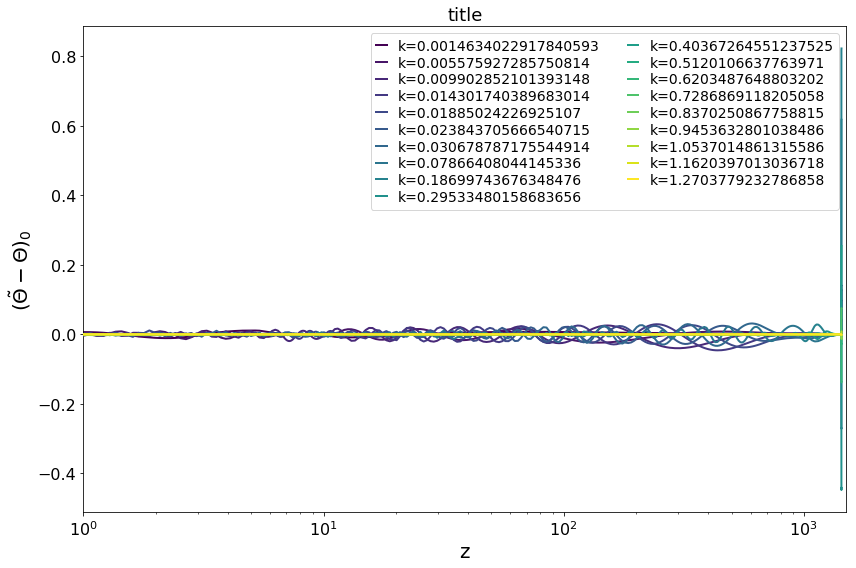

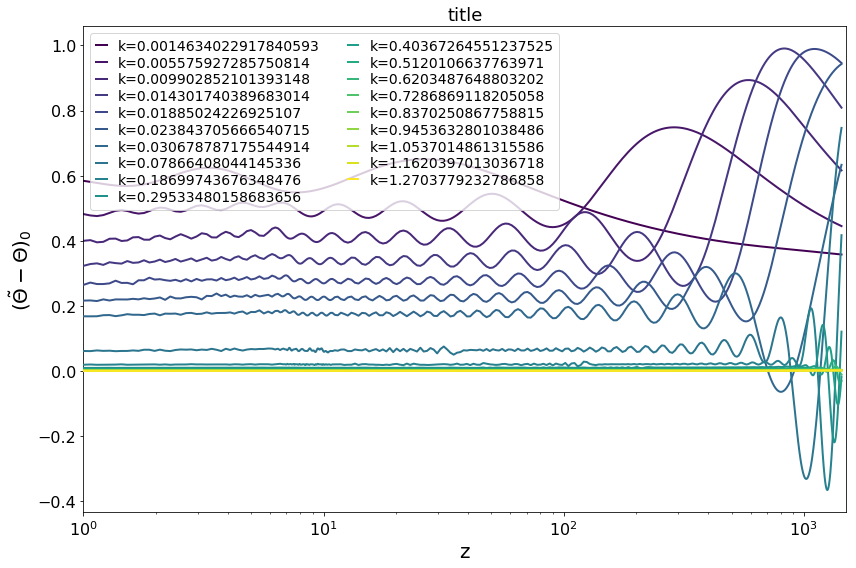

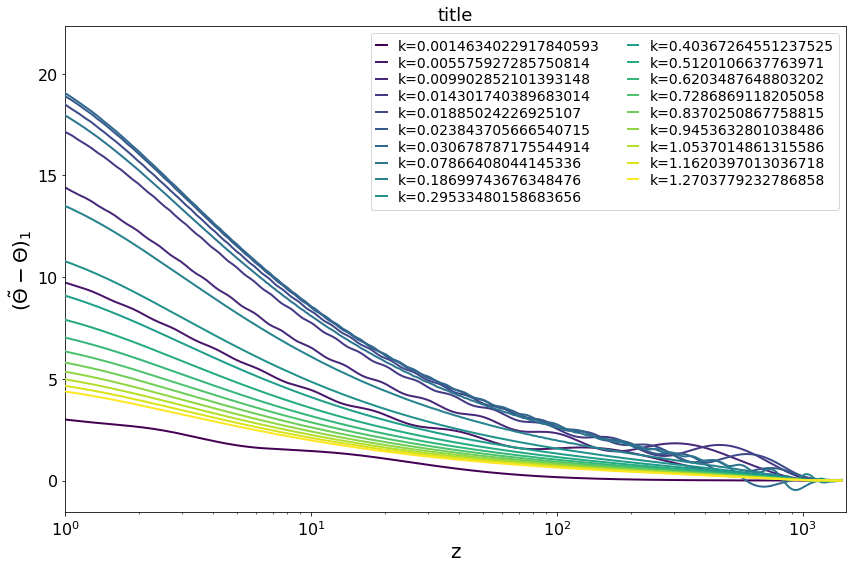

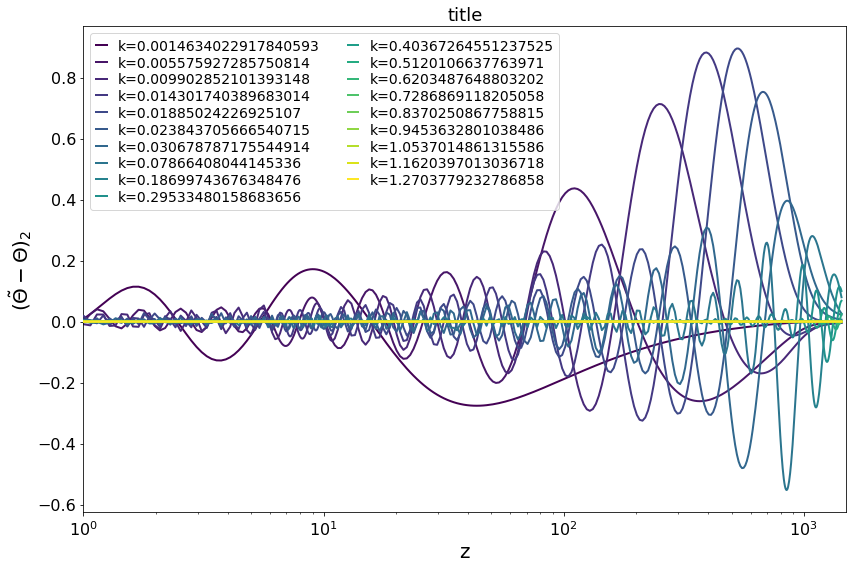

In [36]:
def ylabstr(l):
    return r'$(\tilde{\Theta}-\Theta)_{%s}$' % l
plt.rcParams['figure.figsize']=[12,8]
plot_an(1/a_int(tau)-1,np.swapaxes(-s['delta_g'],0,1)/4.+deltag(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(0),xlim=[1,1500])
plot_an(1/a_int(tau)-1,np.swapaxes(-s['delta_g'],0,1)/4.,k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(0),xlim=[1,1500])

plot_an(1/a_int(tau)-1,np.swapaxes(-s['theta_g']+s['theta_b'],0,1)/k,k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(1),xlim=[1,1500])

#plot_an(1/a_int(tau)-1,np.swapaxes(-s['shear_g'],0,1)*5/2.+Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])

this_Pi=(s['shear_g']*2.+s['mult_Pg_0']+s['mult_Pg_2'])/8.

plot_an(1/a_int(tau)-1,np.swapaxes(-s['shear_g']*5/2.+this_Pi,0,1),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])

#plot_an(1/a_int(tau)-1,np.swapaxes(-this_Pi,0,1)+Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])




/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


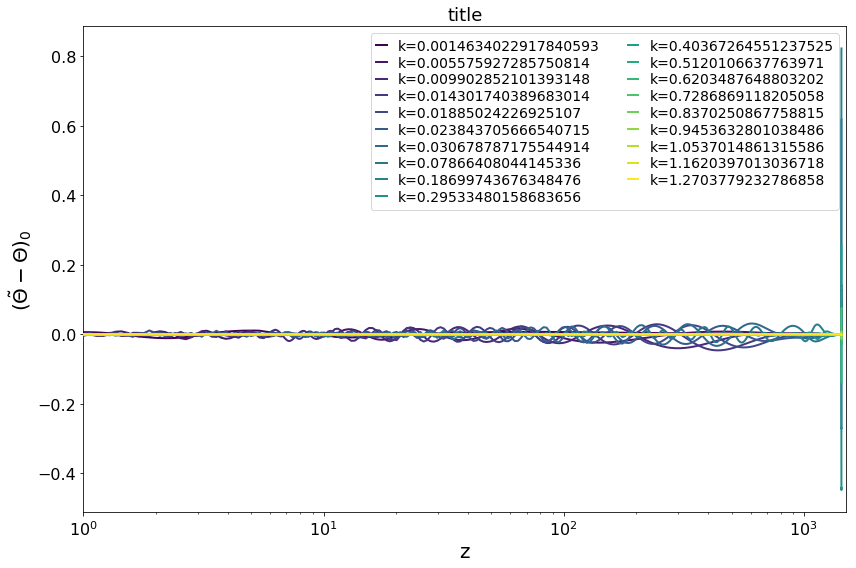

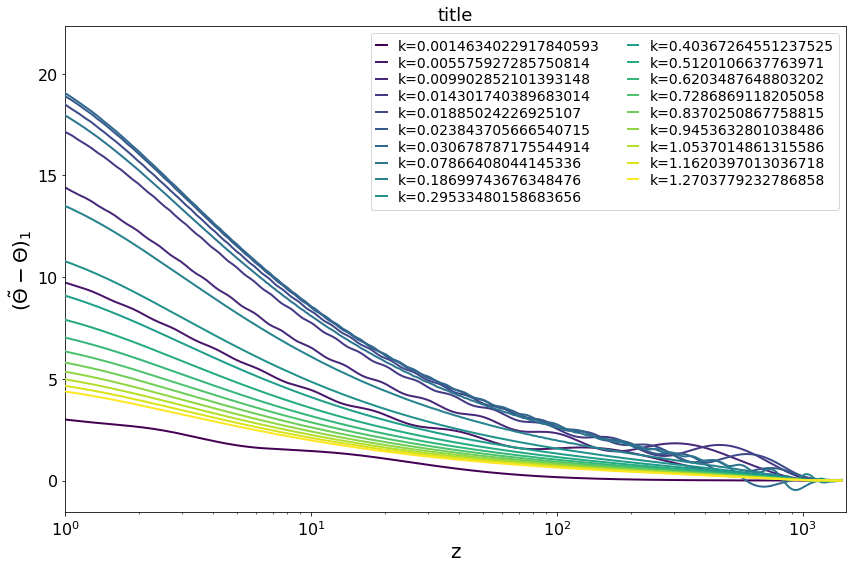

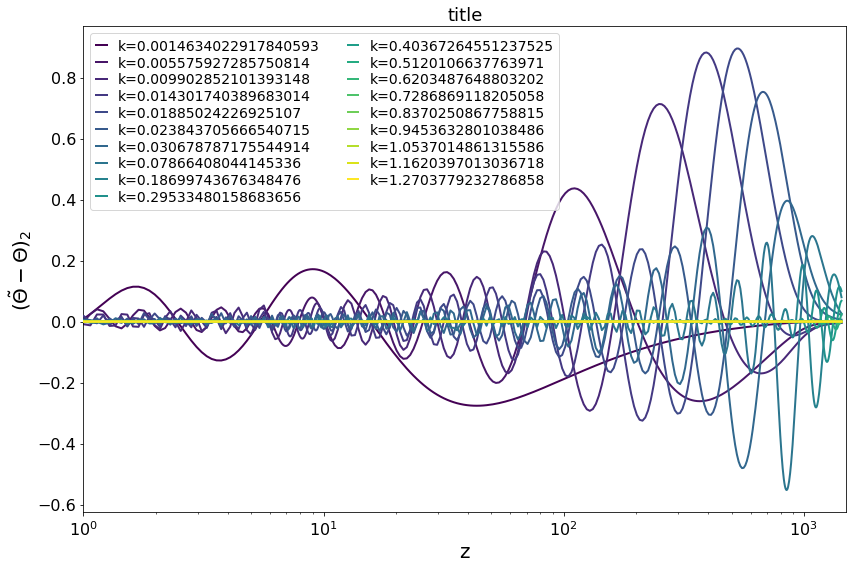

In [9]:
def ylabstr(l):
    return r'$(\tilde{\Theta}-\Theta)_{%s}$' % l
plt.rcParams['figure.figsize']=[12,8]
plot_an(1/a_int(tau)-1,np.swapaxes(-s['delta_g'],0,1)/4.+deltag(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(0),xlim=[1,1500])
plot_an(1/a_int(tau)-1,np.swapaxes(-s['delta_g'],0,1)/4.,k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(0),xlim=[1,1500])

plot_an(1/a_int(tau)-1,np.swapaxes(-s['theta_g']+s['theta_b'],0,1)/k,k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(1),xlim=[1,1500])

#plot_an(1/a_int(tau)-1,np.swapaxes(-s['shear_g'],0,1)*5/2.+Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])

this_Pi=(s['shear_g']*2.+s['mult_Pg_0']+s['mult_Pg_2'])/8.

plot_an(1/a_int(tau)-1,np.swapaxes(-s['shear_g']*5/2.+this_Pi,0,1),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])

#plot_an(1/a_int(tau)-1,np.swapaxes(-this_Pi,0,1)+Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])




/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


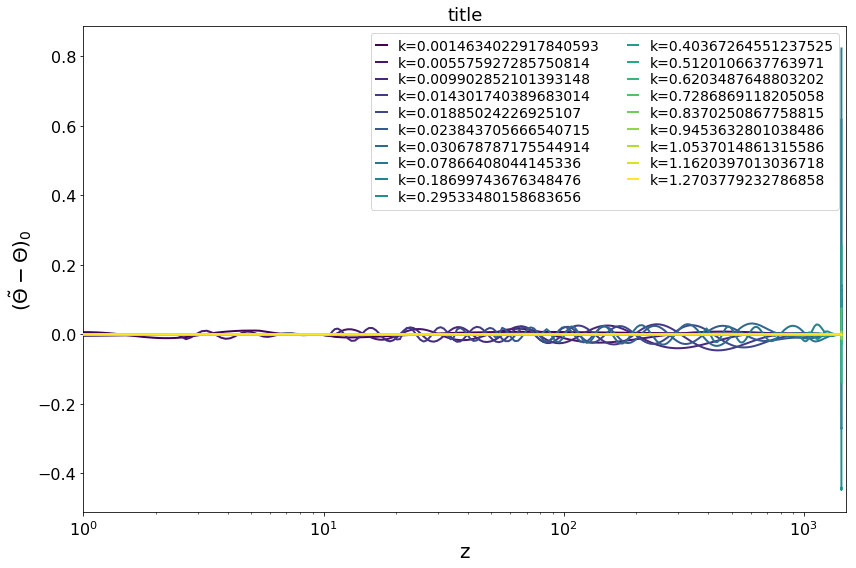

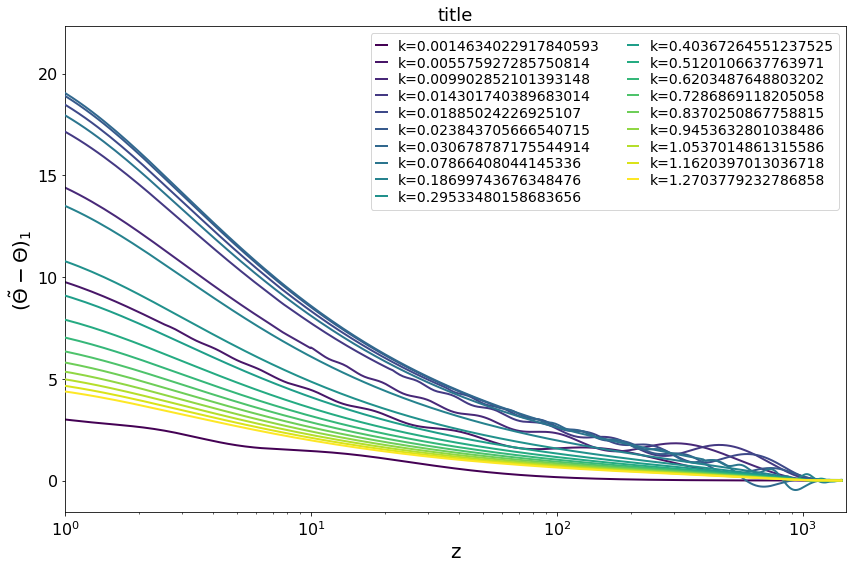

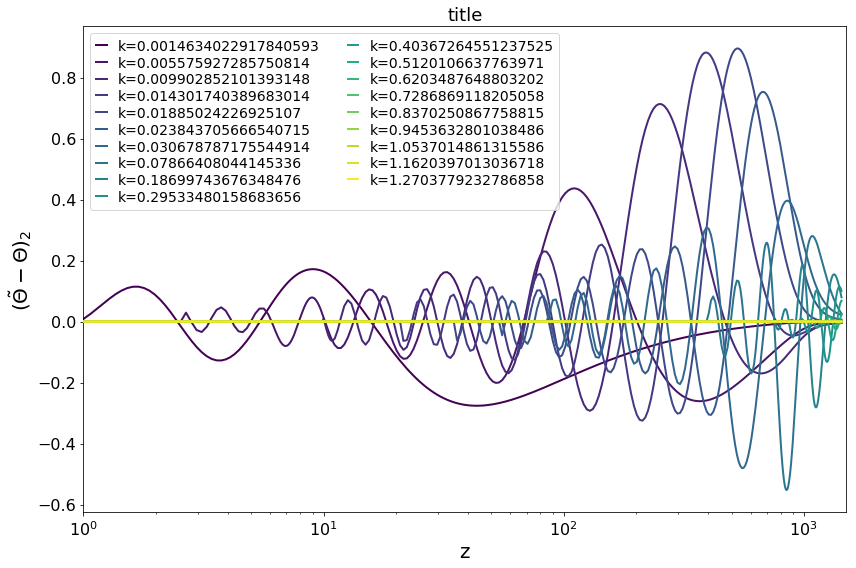

In [29]:
def ylabstr(l):
    return r'$(\tilde{\Theta}-\Theta)_{%s}$' % l
plot_an(1/a_int(tau)-1,np.swapaxes(-s['delta_g'],0,1)/4.+deltag(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(0),xlim=[1,1500])
plot_an(1/a_int(tau)-1,np.swapaxes(-s['theta_g']+s['theta_b'],0,1)/k,k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(1),xlim=[1,1500])

#plot_an(1/a_int(tau)-1,np.swapaxes(-s['shear_g'],0,1)*5/2.+Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])

this_Pi=(s['shear_g']*2.+s['mult_Pg_0']+s['mult_Pg_2'])/8.

plot_an(1/a_int(tau)-1,np.swapaxes(-s['shear_g']*5/2.+this_Pi,0,1),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])

#plot_an(1/a_int(tau)-1,np.swapaxes(-this_Pi,0,1)+Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])




/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeW

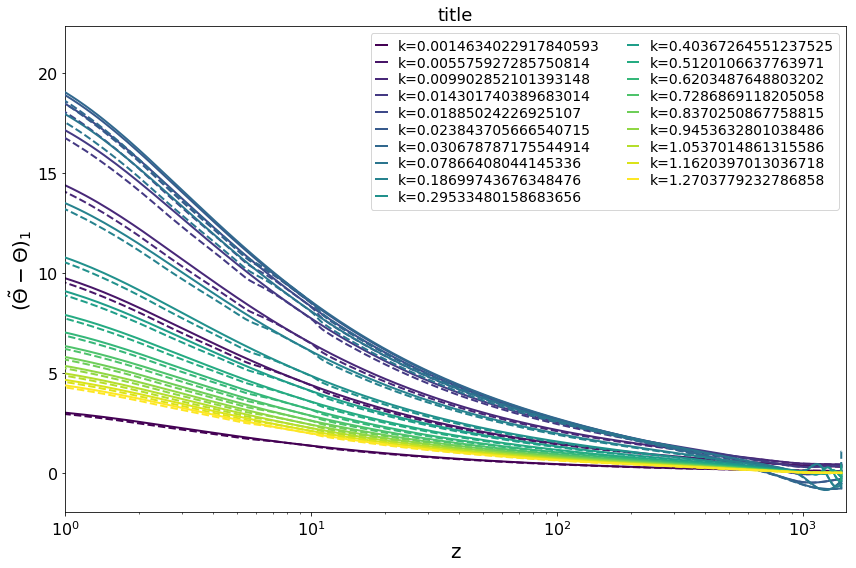

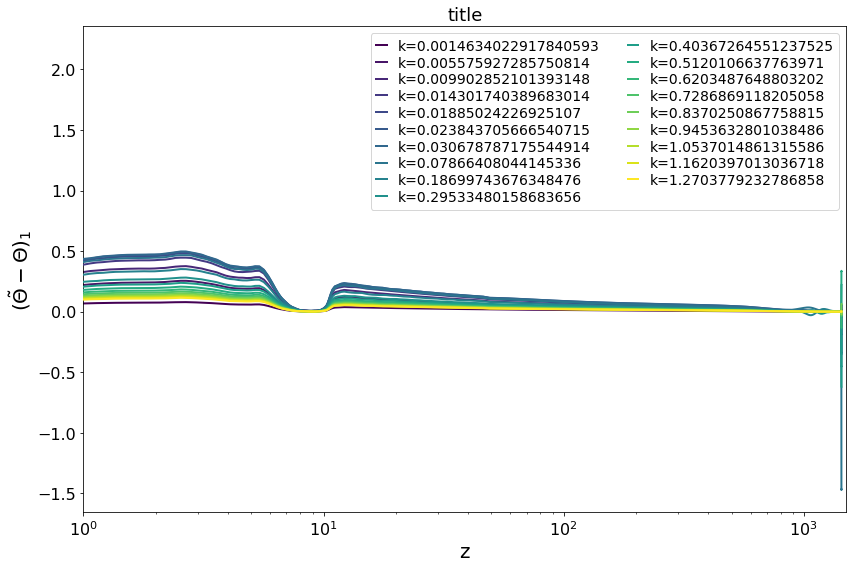

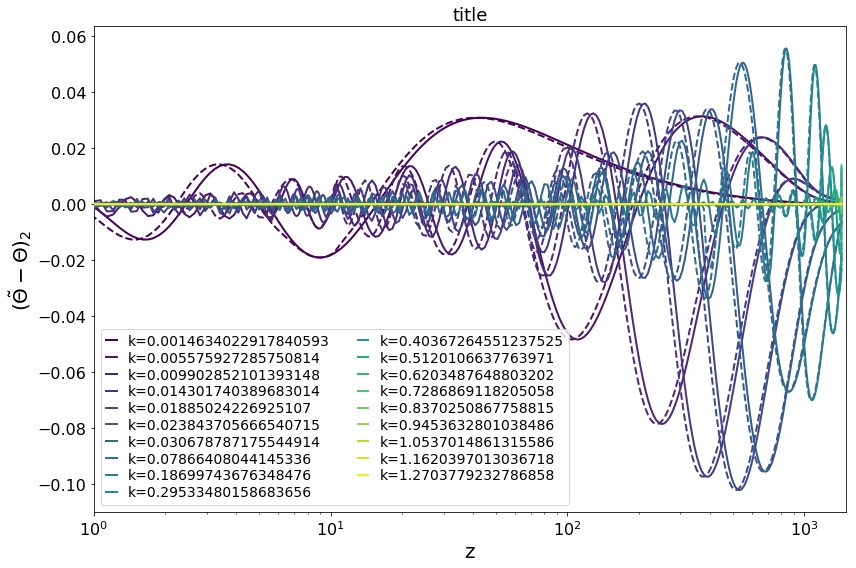

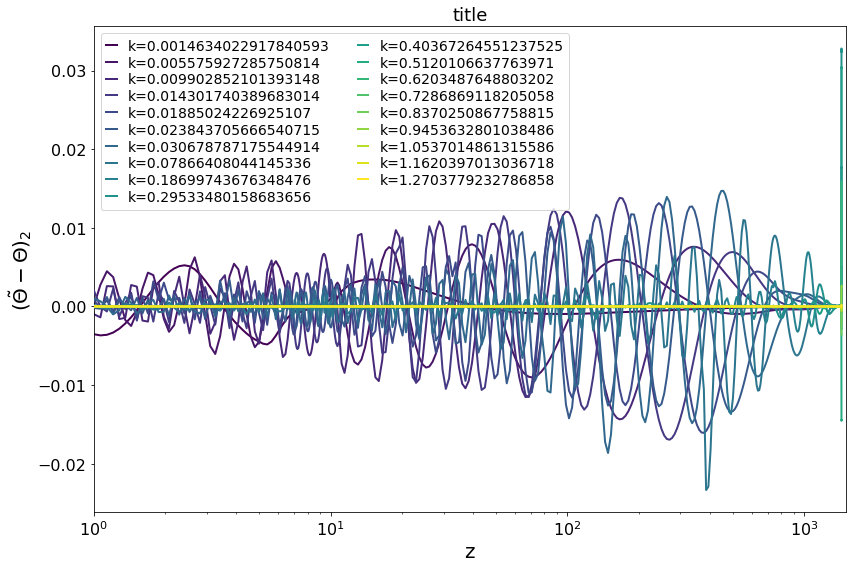

In [10]:
fig,ax=plt.subplots(1,1)


plot_an(1/a_int(tau)-1,(np.swapaxes(s['theta_b'],0,1))/k,k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(1),xlim=[1,1500],fig=fig,ax=ax)
plot_an(1/a_int(tau)-1,thetab(k,a_int(tau))/k,k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(1),xlim=[1,1500],legendbool=False,fig=fig,ax=ax,linestyle='--')

plot_an(1/a_int(tau)-1,(np.swapaxes(s['theta_b'],0,1)-thetab(k,a_int(tau)))/k,k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(1),xlim=[1,1500])

fig,ax=plt.subplots(1,1)

plot_an(1/a_int(tau)-1,np.swapaxes(this_Pi,0,1),k,kplot[1:],legstr='k=',xlabel='z',ylabel=r'$\Theta_b$',xlim=[1,1500],fig=fig,ax=ax)
plot_an(1/a_int(tau)-1,Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500],fig=fig,ax=ax,linestyle='--',legendbool=False)

plot_an(1/a_int(tau)-1,np.swapaxes(-this_Pi,0,1)+Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])




/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


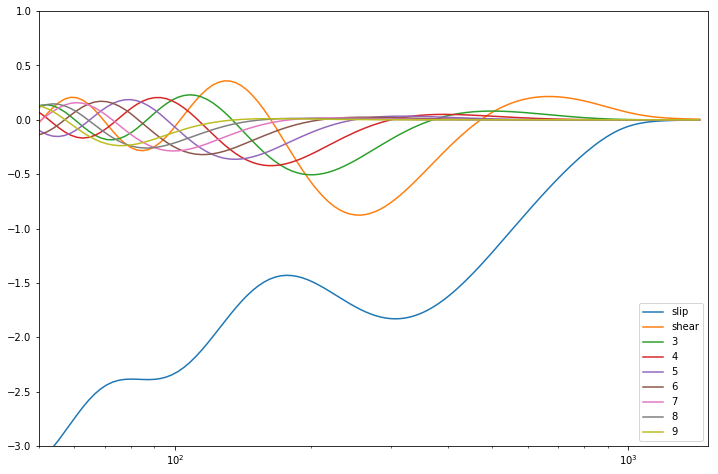

In [33]:
fig,ax=plt.subplots(1,1)
indx=find_nearest(k,1e-2)
#ax.plot(1/a_int(tau)-1,s['delta_g'][indx,:])
ax.plot(1/a_int(tau)-1,(s['theta_g']-s['theta_b'])[indx,:]/1e-2,label='slip')
#ax.plot(1/a_int(tau)-1,(s['theta_g'])[indx,:]/1e-2,label='theta_g')

ax.plot(1/a_int(tau)-1,(s['shear_g']*5/2.+this_Pi)[indx,:],label='shear')

for l in np.arange(3,10):
    ax.plot(1/a_int(tau)-1,s['mult_Tg_{}'.format(l)][indx,:],label='%s' % l)
ax.set_xscale('log')
ax.set_xlim([50,1500])
ax.set_ylim([-3,1])
ax.legend()

/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


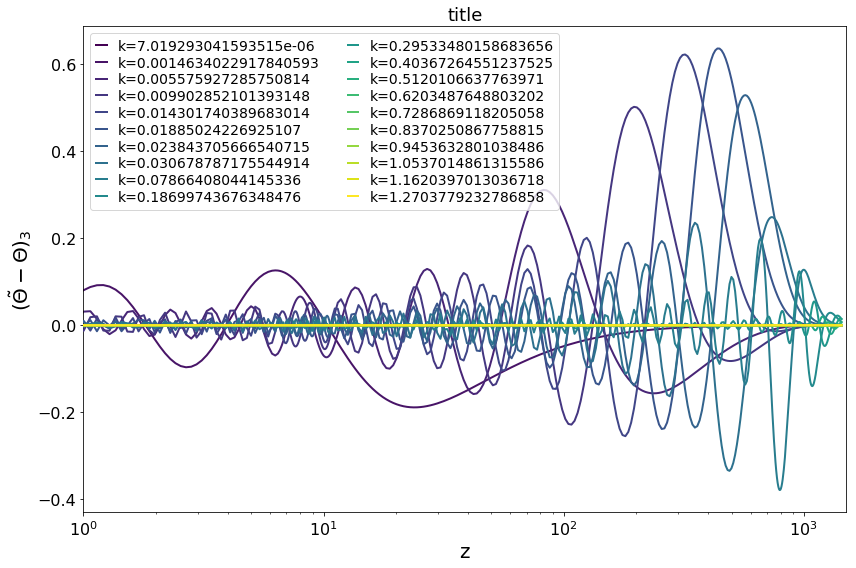

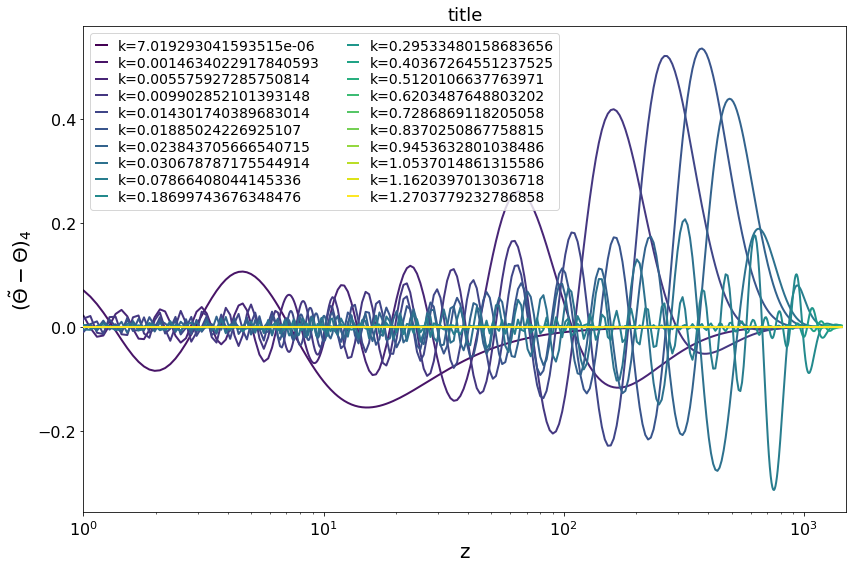

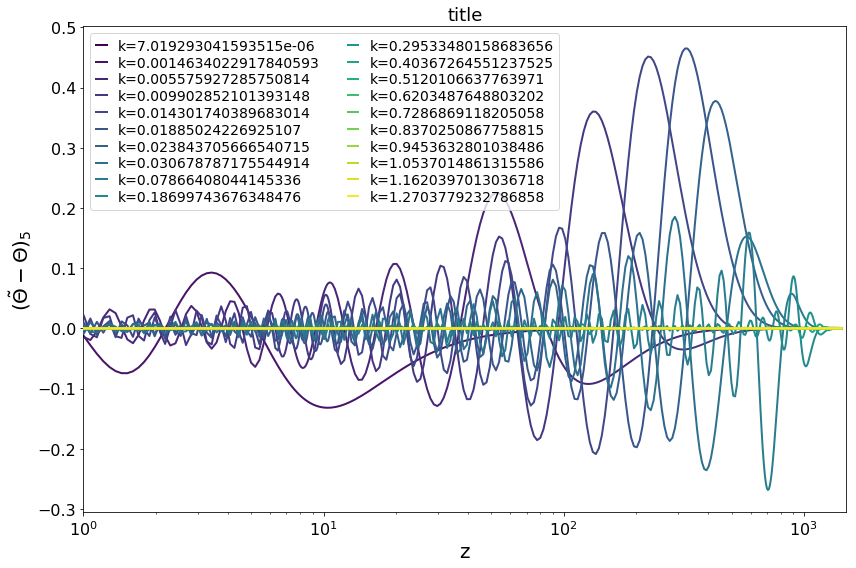

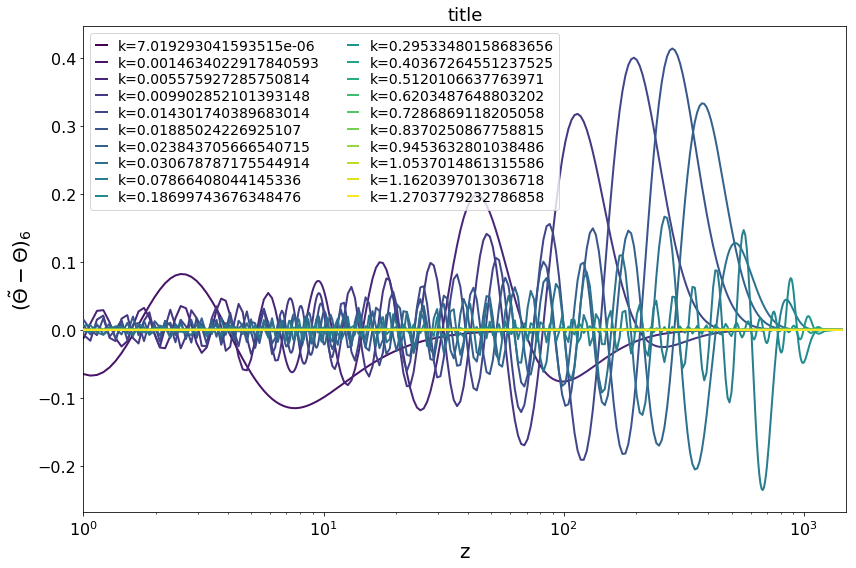

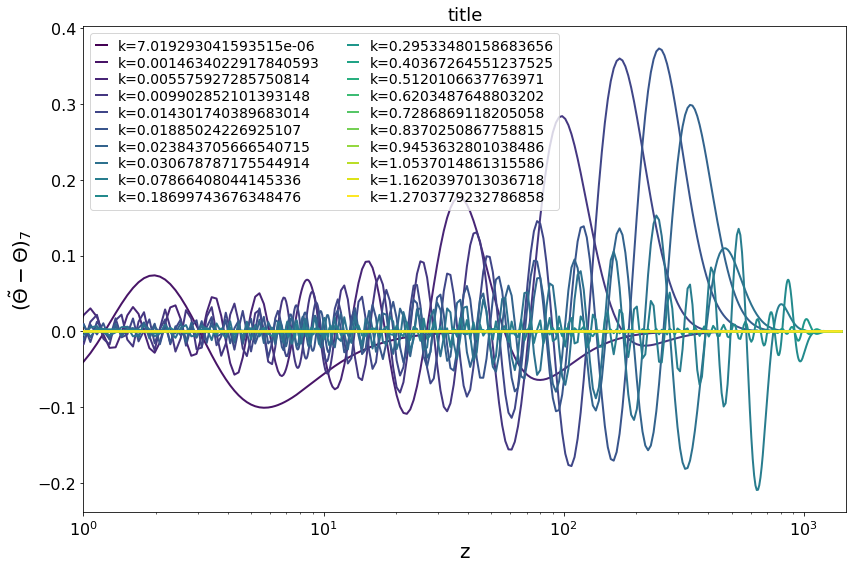

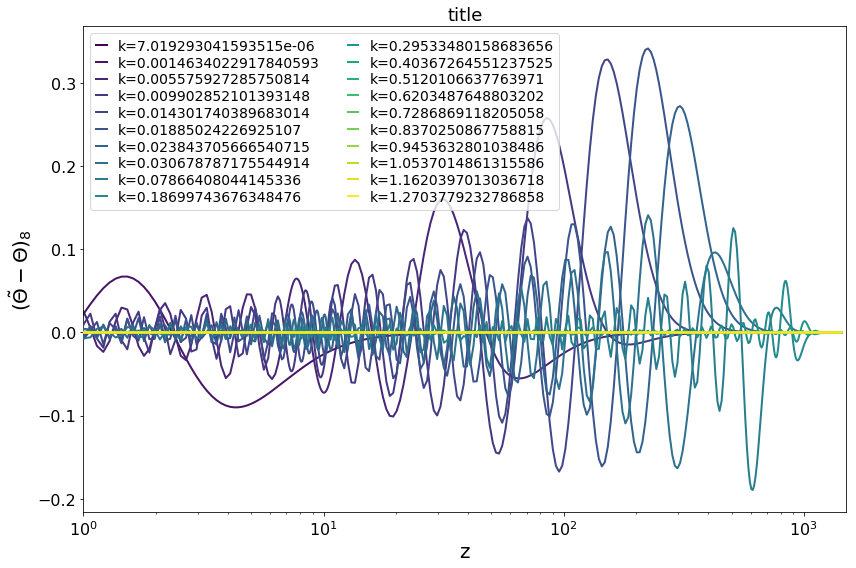

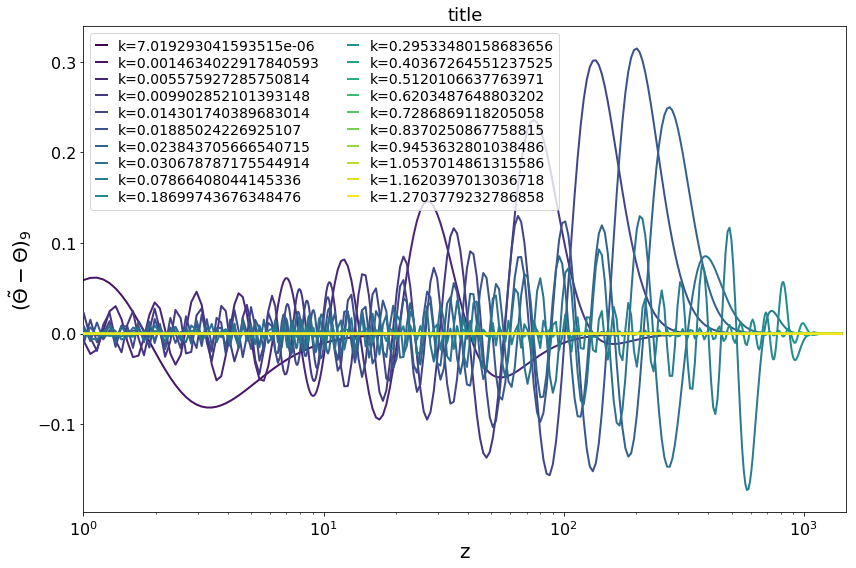

In [11]:

for l in np.arange(3,10):
    plot_an(1/a_int(tau)-1,-np.swapaxes(s['mult_Tg_{}'.format(l)],0,1),k,kplot,legstr='k=',xlabel='z',ylabel=ylabstr(l),xlim=[1,1500])



/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


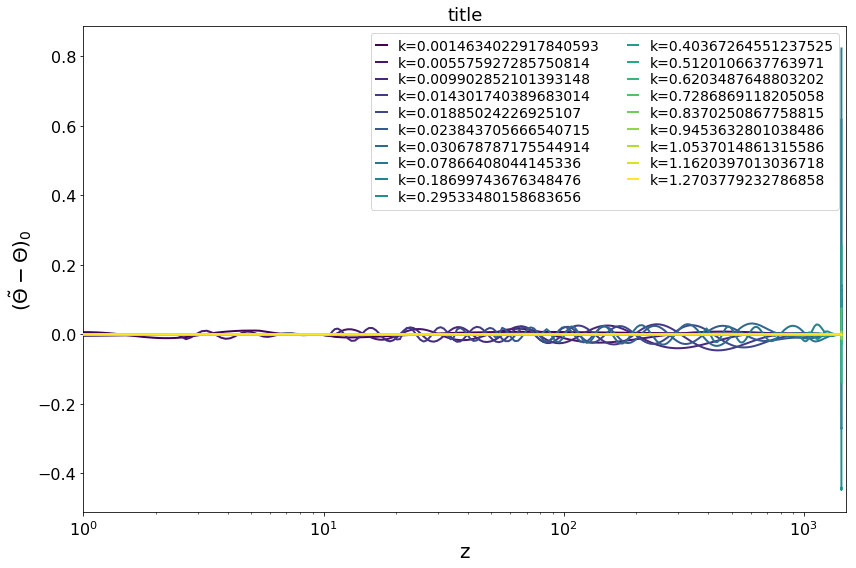

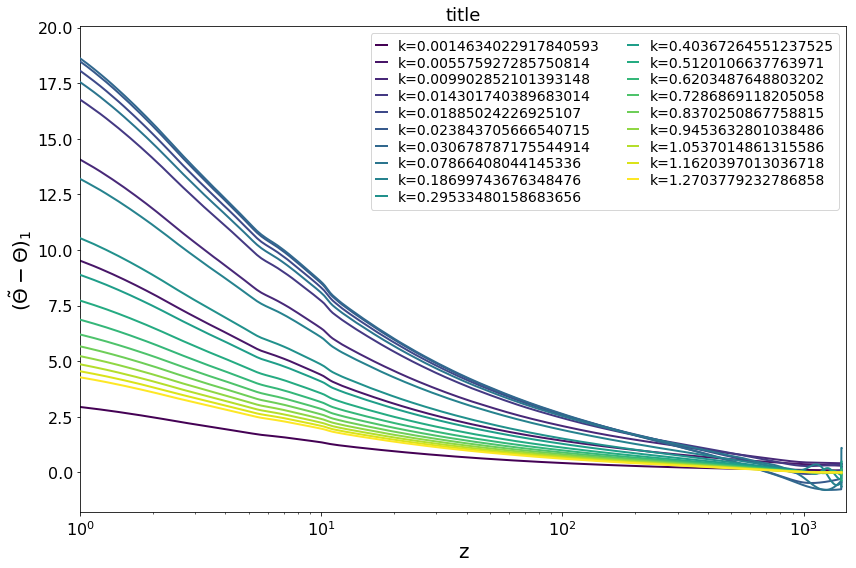

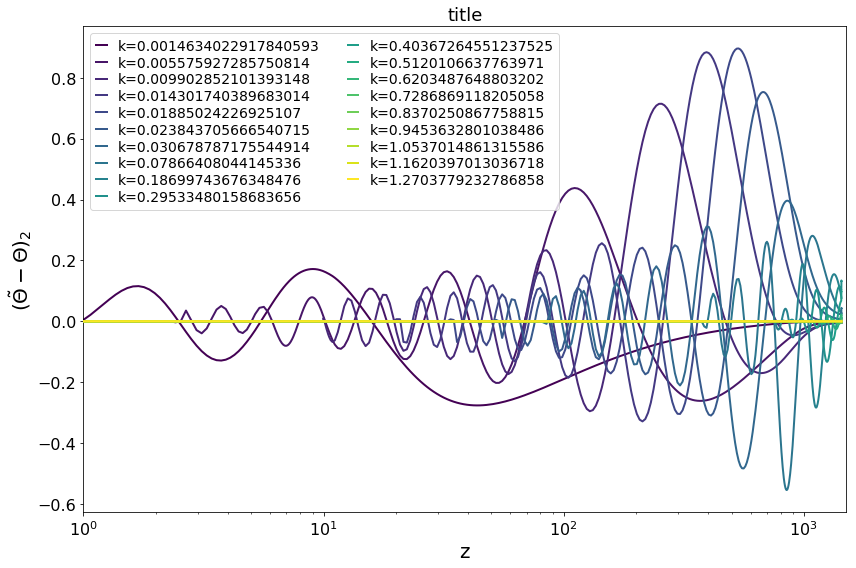

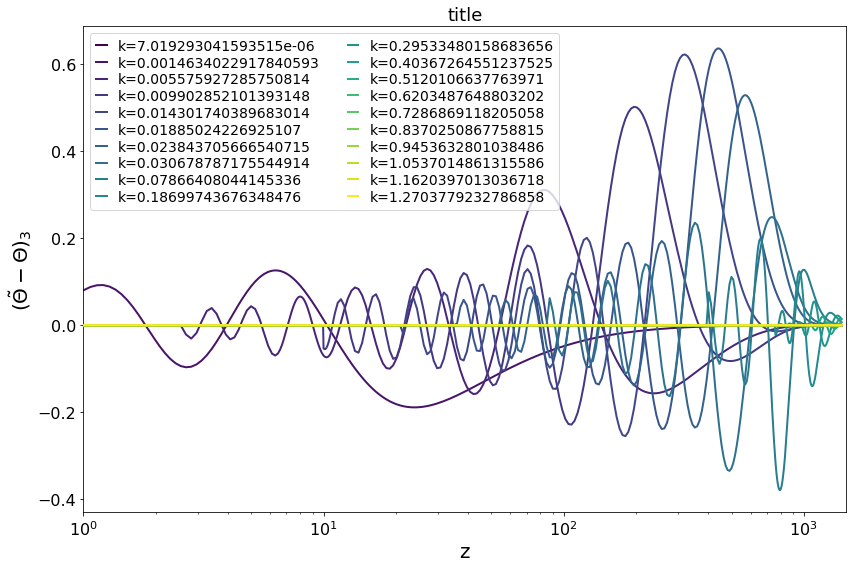

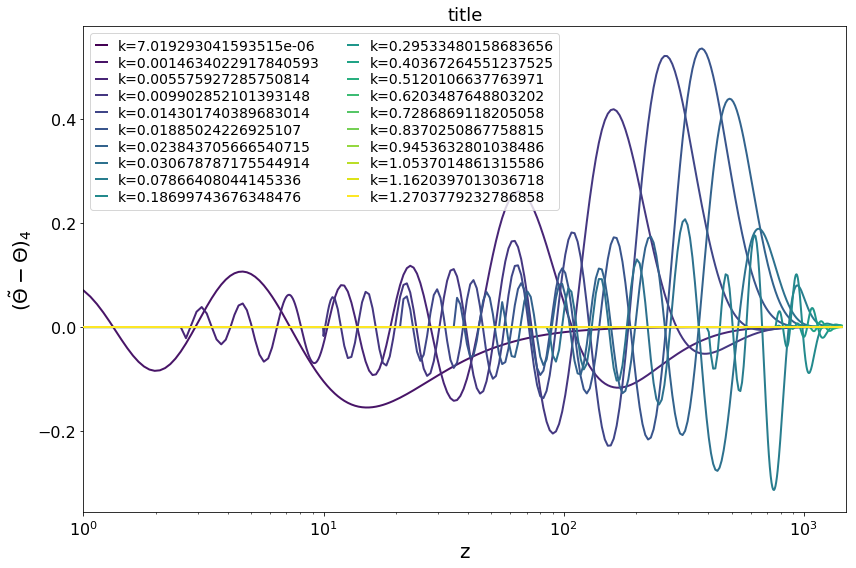

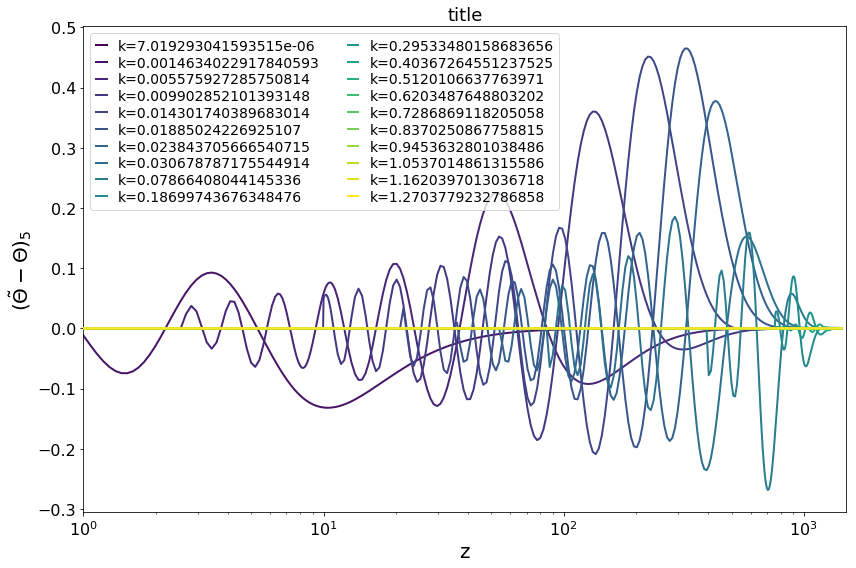

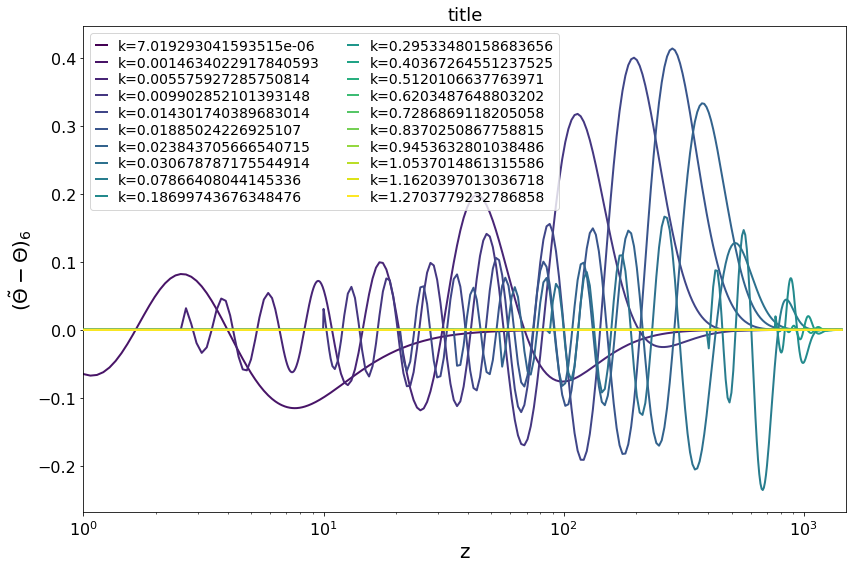

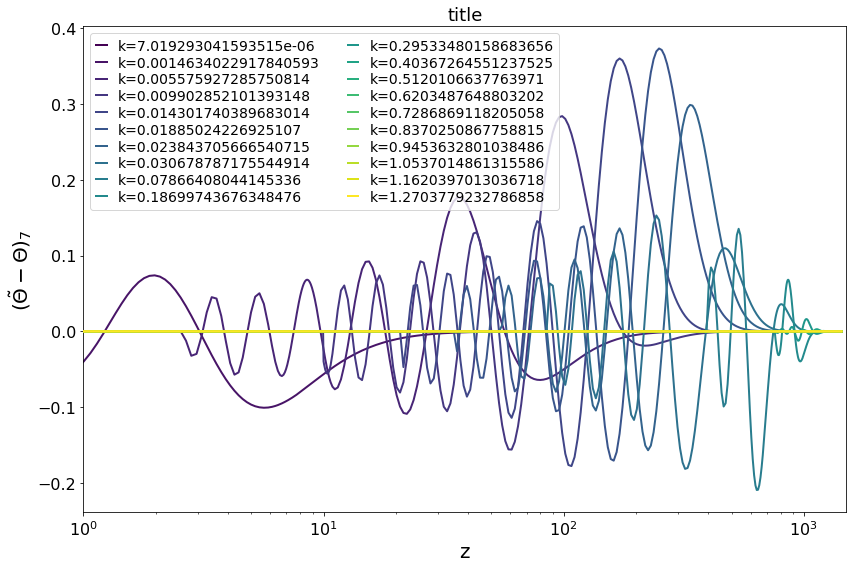

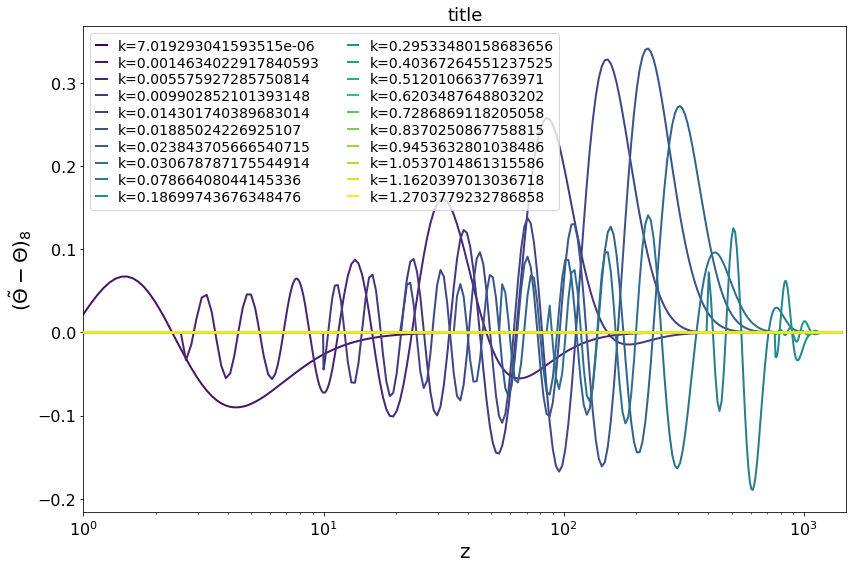

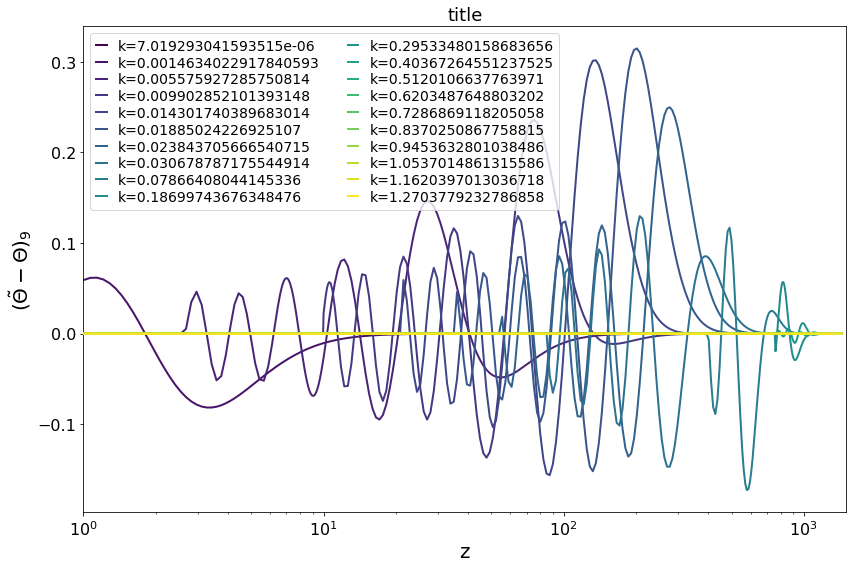

In [139]:
def ylabstr(l):
    return r'$(\tilde{\Theta}-\Theta)_{%s}$' % l
plot_an(1/a_int(tau)-1,np.swapaxes(-s['delta_g'],0,1)/4.+deltag(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(0),xlim=[1,1500])
plot_an(1/a_int(tau)-1,-np.swapaxes(s['theta_g'],0,1)+thetab(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(1),xlim=[1,1500])
plot_an(1/a_int(tau)-1,-np.swapaxes(s['shear_g'],0,1)*5/2.+Pi(k,a_int(tau)),k,kplot[1:],legstr='k=',xlabel='z',ylabel=ylabstr(2),xlim=[1,1500])

for l in np.arange(3,10):
    plot_an(1/a_int(tau)-1,-np.swapaxes(s['mult_Tg_{}'.format(l)],0,1),k,kplot,legstr='k=',xlabel='z',ylabel=ylabstr(l),xlim=[1,1500])




/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


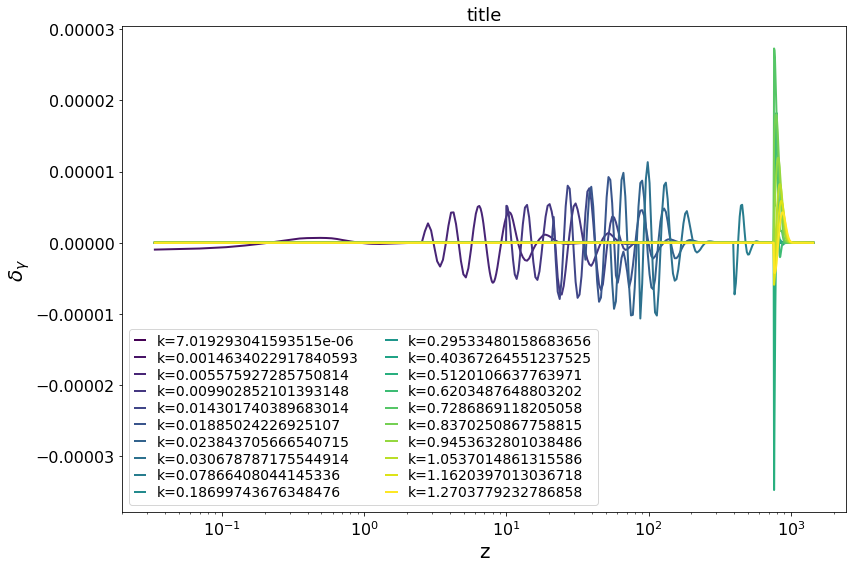

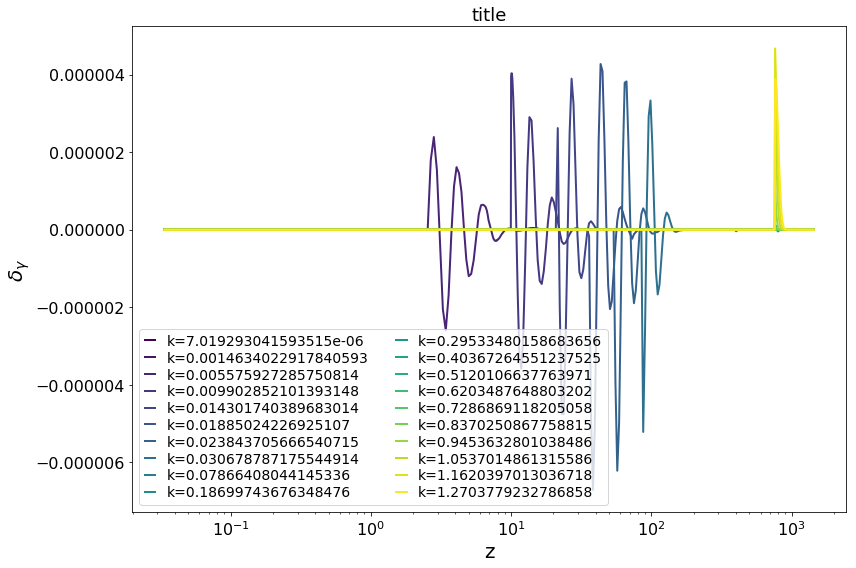

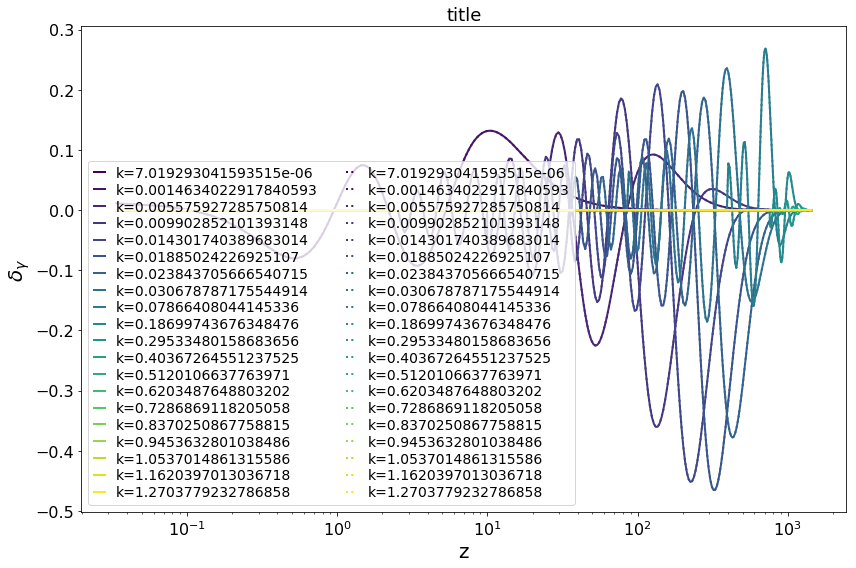

In [68]:
plt.rcParams['figure.figsize']=[12,8]
mult=5
plot_an(1/a_int(tau)-1,np.swapaxes(s['mult_Tg_{}'.format(mult)]-s_hi['mult_Tg_{}'.format(mult)],0,1),k,kplot,legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$')
plot_an(1/a_int(tau)-1,np.swapaxes(s_hi['mult_Tg_{}'.format(mult)]-s_hihi['mult_Tg_{}'.format(mult)],0,1),k,kplot,legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$')


fig,ax=plt.subplots(1,1)
plot_an(1/a_int(tau)-1,np.swapaxes(s['mult_Tg_{}'.format(mult)],0,1),k,kplot,legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$',fig=fig,ax=ax)
plot_an(1/a_int(tau_Hi)-1,np.swapaxes(s_hi['mult_Tg_{}'.format(mult)],0,1),k_hi,kplot,legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$',fig=fig,ax=ax,linestyle=':')

#plot_an(1/a_tmp-1,thet0_out,k_tmp,k[::50],legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$',fig=fig,ax=ax,linestyle=':',legendbool=False)



/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


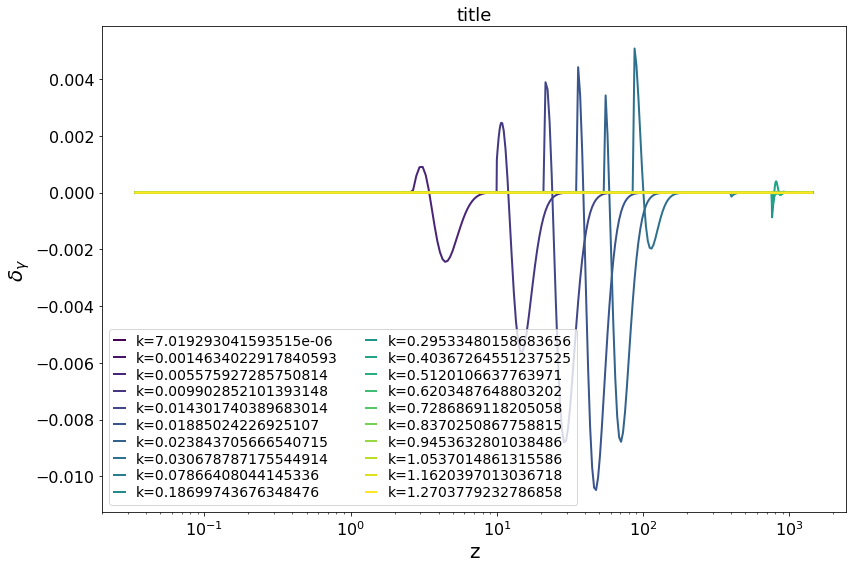

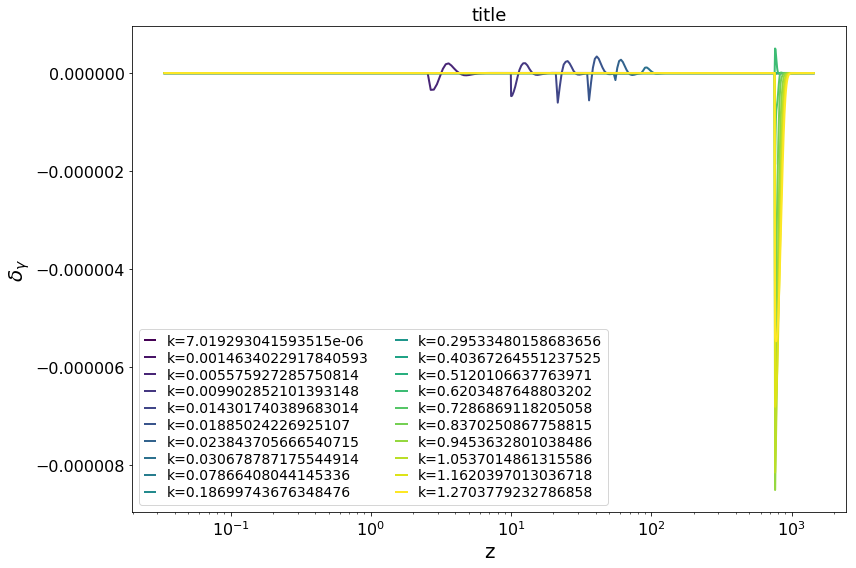

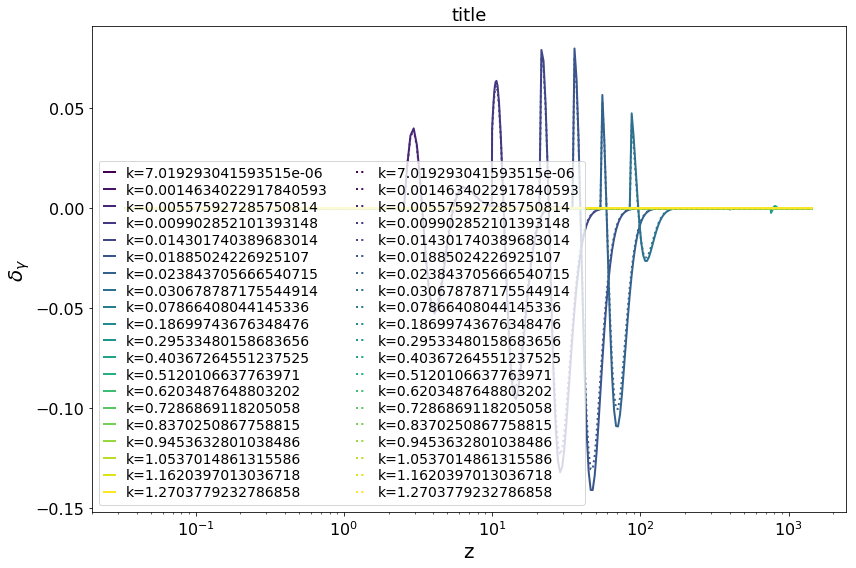

In [69]:
mult=30
plot_an(1/a_int(tau)-1,np.swapaxes(s['mult_Tg_{}'.format(mult)]-s_hi['mult_Tg_{}'.format(mult)],0,1),k,kplot,legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$')
plot_an(1/a_int(tau)-1,np.swapaxes(s_hi['mult_Tg_{}'.format(mult)]-s_hihi['mult_Tg_{}'.format(mult)],0,1),k,kplot,legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$')

fig,ax=plt.subplots(1,1)
plot_an(1/a_int(tau)-1,np.swapaxes(s['mult_Tg_{}'.format(mult)],0,1),k,kplot,legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$',fig=fig,ax=ax)
plot_an(1/a_int(tau_Hi)-1,np.swapaxes(s_hi['mult_Tg_{}'.format(mult)],0,1),k_hi,kplot,legstr='k=',xlabel='z',ylabel=r'$\delta_\gamma$',fig=fig,ax=ax,linestyle=':')

In [40]:
print(np.max(k))

1.3483814463917283


In [23]:
print(np.max(k))

0.42317347983044984


/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/Acolyte/opt/anaconda3/envs/CLASS/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


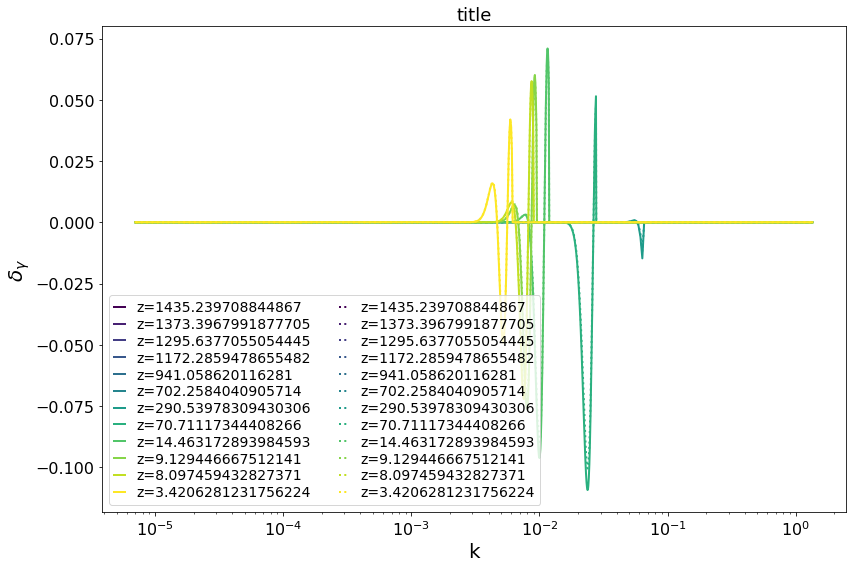

In [54]:
plt.rcParams['figure.figsize']=[12,8]
fig,ax=plt.subplots(1,1)
zplot=(1/a_int(tau)-1)[::50]
mult=30
plot_an(k,(s['mult_Tg_{}'.format(mult)]),1/a_int(tau)-1,zplot,legstr='z=',xlabel='k',ylabel=r'$\delta_\gamma$',fig=fig,ax=ax)
plot_an(k_hi,(s_hi['mult_Tg_{}'.format(mult)]),1/a_int(tau_Hi)-1,zplot,legstr='z=',xlabel='k',ylabel=r'$\delta_\gamma$',fig=fig,ax=ax,linestyle=':')

#plot_an(k_tmp[k_tmp < np.max(k)],np.swapaxes(thet0_out[:,k_tmp < np.max(k)],0,1),1/a_tmp-1,zplot,legstr='z=',xlabel='k',ylabel=r'$\delta_\gamma$',fig=fig,ax=ax,linestyle=':',legendbool=False)
